In [1]:
from dataclasses import dataclass
from typing import Literal

import jax.numpy as jp
import matplotlib.pyplot as plt
import numpy as np
import softjax as sj



# Manifold Points

This notebook provides an example of how to translate a hard jax function into a **softjax** function in practice.

As the worked example, we consider Mujoco MJX's convex collision detection algorithm, which has a [subroutine](https://github.com/google-deepmind/mujoco/blob/main/mjx/mujoco/mjx/_src/collision_convex.py#L112) that chooses four vertices (A, B, C, D) that roughly maximize the contact patch area. 


## Original function

The steps of the selection algorithm are

1. Pick A: any unmasked vertex (in MJX this is the most penetrating one).
2. Pick B: the vertex farthest from A (long base edge).
3. Pick C: the vertex farthest from line AB within the plane (opens the area).
4. Pick D: the vertex farthest from both edges AC and BC.


In [2]:
# Hard manifold selector mirrored from MJX (collision_convex.py)
def manifold_points_mjx(
    poly: jp.ndarray, poly_mask: jp.ndarray, poly_norm: jp.ndarray
) -> jp.ndarray:
    """MJX hard manifold heuristic (returns 4 vertex indices)."""
    dist_mask = jp.where(poly_mask, 0.0, -1e6)
    # A: any unmasked vertex (in MJX this corresponds to the most penetrating one)
    # Note: We add a small tie-breaker to ensure consistent results
    a_idx = jp.argmax(dist_mask - 0.1 * jp.arange(poly.shape[0]))
    a = poly[a_idx]
    # B: farthest from A (largest squared distance)
    b_idx = (((a - poly) ** 2).sum(axis=1) + dist_mask).argmax()
    b = poly[b_idx]
    # C: farthest from the AB line within the plane
    ab = jp.cross(poly_norm, a - b)
    ap = a - poly
    c_idx = (jp.abs(ap.dot(ab)) + dist_mask).argmax()
    c = poly[c_idx]
    # D: farthest from edges AC and BC
    ac = jp.cross(poly_norm, a - c)
    bc = jp.cross(poly_norm, b - c)
    bp = b - poly
    dist_bp = jp.abs(bp.dot(bc)) + dist_mask
    dist_ap = jp.abs(ap.dot(ac)) + dist_mask
    d_idx = (dist_bp + dist_ap).argmax() % poly.shape[0]
    return jp.array([a_idx, b_idx, c_idx, d_idx])



## SoftJax version

To make this algorithm smoothly differentiable we convert it to softjax. For this, we:

- replace discrete `argmax` with `sj.argmax`, which returns a `SoftIndex` distribution,
- replace the hard indexing with `sj.dynamic_index_in_dim`, which uses the `SoftIndex` as input,
- replace `abs` with `sj.abs`.

Note that we now return four `SoftIndex` distributions (shape: 4 x n) instead of the hard indices.
The remaining code of the collision detection therefore would need to be adjusted accordingly.


In [3]:
def manifold_points_softjax(
    poly: jp.ndarray,
    poly_mask: jp.ndarray,
    poly_norm: jp.ndarray,
    *,
    softness: float = 1.0,
    mode: Literal["hard", "soft"] = "soft",
) -> jp.ndarray:
    """Soft counterpart of `manifold_points_mjx`.

    Returns 4 SoftIndex distributions (shape: 4 x n).
    """
    dist_mask = jp.where(poly_mask, 0.0, -1e6)

    def argmax_soft(x):
        m = "entropic" if mode == "soft" else "hard"
        return sj.argmax(x, mode=m, softness=softness, axis=0)

    def abs_soft(x):
        m = "sigmoid" if mode == "soft" else "hard"
        return sj.abs(x, mode=m, softness=softness)

    # A: soft argmax over masked distances
    a_idx = argmax_soft(dist_mask - 0.1 * jp.arange(poly.shape[0]))
    a = sj.dynamic_index_in_dim(poly, a_idx, axis=0, keepdims=False)
    # B: soft argmax of distance from A
    b_logits = (((a - poly) ** 2).sum(axis=1)) + dist_mask
    b_idx = argmax_soft(b_logits)
    b = sj.dynamic_index_in_dim(poly, b_idx, axis=0, keepdims=False)
    # C: soft argmax farthest from AB line
    ab = jp.cross(poly_norm, a - b)
    ap = a - poly
    c_logits = abs_soft(ap.dot(ab)) + dist_mask
    c_idx = argmax_soft(c_logits)
    c = sj.dynamic_index_in_dim(poly, c_idx, axis=0, keepdims=False)
    # D: soft argmax farthest from AC and BC edges
    ac = jp.cross(poly_norm, a - c)
    bc = jp.cross(poly_norm, b - c)
    bp = b - poly
    dist_bp = abs_soft(bp.dot(bc)) + dist_mask
    dist_ap = abs_soft(ap.dot(ac)) + dist_mask
    d_logits = dist_bp + dist_ap
    d_idx = argmax_soft(d_logits)
    return jp.stack([a_idx, b_idx, c_idx, d_idx], axis=0)



## Visualization

We generate a perturbed planar polygon for visualization.


In [4]:
@dataclass
class Selection:
    poly: np.ndarray
    hard_idx: np.ndarray
    hard_pts: np.ndarray
    soft_runs: list[tuple[float, np.ndarray]]


def make_planar_polygon(
    n: int = 8, radius: float = 1.0, jitter: float = 0.05, seed: int = 0
):
    rng = np.random.RandomState(seed)
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    r = radius * (1.0 + jitter * rng.randn(n))
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    poly2d = np.stack([x, y], axis=1)
    center = poly2d.mean(axis=0)
    angles_ccw = np.arctan2(poly2d[:, 1] - center[1], poly2d[:, 0] - center[0])
    order = np.argsort(angles_ccw)
    poly2d = poly2d[order]
    poly3d = np.concatenate([poly2d, np.zeros((n, 1))], axis=1)
    return jp.array(poly3d)


def order_quad(points: np.ndarray):
    center = points.mean(axis=0)
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    order = np.argsort(angles)
    return points[order]


def run_selection(
    n: int = 16,
    softness: list[float] | tuple[float, ...] = (1.0,),
    mode: str = "entropic",
    seed: int = 0,
) -> Selection:
    poly = make_planar_polygon(n=n, seed=seed)
    mask = jp.ones((n,), dtype=bool)
    normal = jp.array([0.0, 0.0, 1.0])

    hard_idx = np.array(manifold_points_mjx(poly, mask, normal))
    hard_pts = np.array(poly[hard_idx])

    soft_runs = []
    for w in softness:
        soft_probs = manifold_points_softjax(
            poly, mask, normal, softness=float(w), mode=mode
        )
        soft_pts = soft_probs @ np.array(poly)
        soft_runs.append((w, soft_pts))

    return Selection(
        poly=np.array(poly), hard_idx=hard_idx, hard_pts=hard_pts, soft_runs=soft_runs
    )


def plot_multi(sel: Selection, mode: str):
    poly2d = sel.poly[:, :2]
    hull = order_quad(poly2d)
    hull_closed = np.vstack([hull, hull[0]])

    fig, ax = plt.subplots(figsize=(8, 7))
    ax.fill(
        hull_closed[:, 0],
        hull_closed[:, 1],
        color="#dddddd",
        alpha=0.3,
        label="poly hull",
    )
    ax.plot(hull_closed[:, 0], hull_closed[:, 1], color="#999999", lw=1.0)
    ax.scatter(poly2d[:, 0], poly2d[:, 1], color="#444444", s=40, label="verts")

    hard_xy = order_quad(sel.hard_pts[:, :2])
    hard_closed = np.vstack([hard_xy, hard_xy[0]])
    ax.plot(
        hard_closed[:, 0], hard_closed[:, 1], color="#000000", lw=2.0, label="hard_mjx"
    )
    ax.scatter(hard_xy[:, 0], hard_xy[:, 1], color="#000000", s=60, zorder=3)

    cmap = plt.get_cmap("tab10")
    for i, (w, soft_pts) in enumerate(sel.soft_runs):
        soft_xy = order_quad(np.array(soft_pts)[:, :2])
        soft_closed = np.vstack([soft_xy, soft_xy[0]])
        color = cmap(i % cmap.N)
        ax.plot(
            soft_closed[:, 0],
            soft_closed[:, 1],
            color=color,
            lw=2.0,
            ls="--",
            label=f"soft w={w}",
        )
        ax.scatter(soft_xy[:, 0], soft_xy[:, 1], color=color, s=55, zorder=3)

    ax.set_aspect("equal", adjustable="datalim")
    ax.set_title(f"Hard vs soft manifold points (mode={mode})")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.2)
    plt.show()


We first check, that in `hard` mode our softjax version matches the original mjx selection.

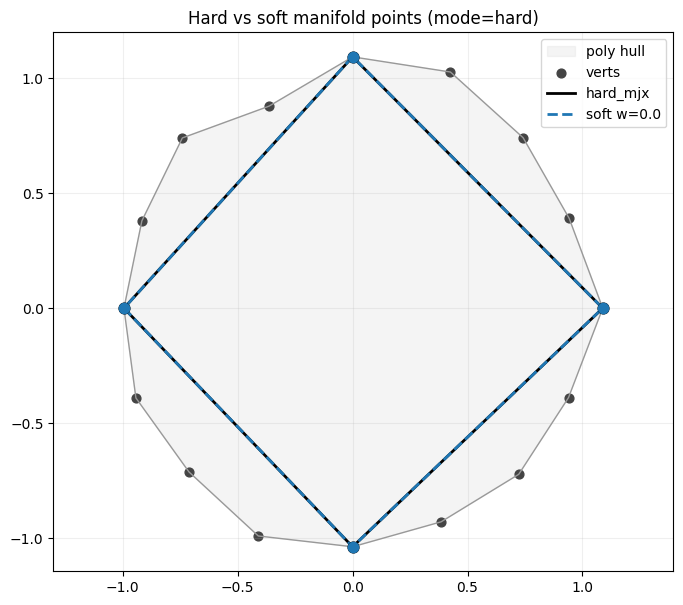

In [5]:
sel = run_selection(softness=(0.0,), mode="hard", seed=0)
plot_multi(sel, mode="hard")

Next, we visualize the relaxations for two different modes.

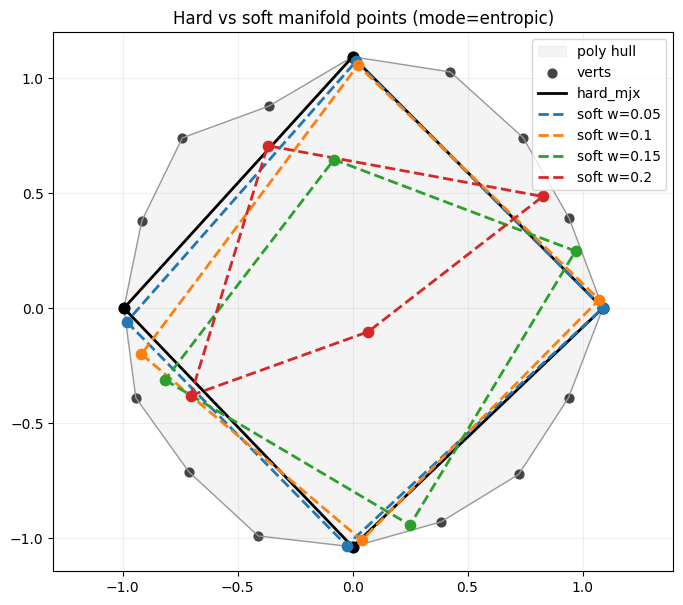

In [6]:
sel = run_selection(softness=[0.05, 0.1, 0.15, 0.2], mode="soft", seed=0)
plot_multi(sel, mode="entropic")


## Straight-through estimation

We could now directly use one of the relaxations as a differentiable proxy.
However, sometimes it is desired to not alter the forward pass, e.g. in simulation we do not
want to relaxt the forward physics. In these cases, we can resort to the straight-through
trick, which means to replace only the gradient of a hard function on forward with the gradeint 
of a relaxed/soft function on backward pass.
`softjax.straight_through.st` implements this behavior by wrapping a function so that the 
forward pass uses a hard definition while the backward pass uses a soft surrogate.
For convenience, we all ready provide wrapped versions of all our primitives, allowing the user to just
use e.g. `sj.argmax_st` instead of `sj.argmax`.

However, as described in the all-of-softjax notebook, this can still lead to uninformative gradients
due to the interaction of the straight-through trick with the chain rule.
A way to avoid this issue is to apply the straight-through trick on the outer level of the
downstream function, which calls the whole function twice instead of each of the primitives.
This is illustrated below.


In [7]:
from softjax.straight_through import st

manifold_points_softjax_st = st(manifold_points_softjax)

The `manifold_points_softjax_st` now still has the discrete one-hot outputs of the hard function, 
but provides the gradients of the relaxed version.